# Домашнее задание

Работаем с датасетом про дорожные знаки.

https://www.kaggle.com/datasets/valentynsichkar/traffic-signs-preprocessed/data

В первых двух задачах берем только файл train.pickle и можно подгрузить labels_names.csv

Данные можно прочитать через `pd.read_pickle`

## Easy

Скачать датасет, обучить логистическую регрессию, измерить качество.

Текстом кратко обосновать какую метрику выбираем и почему такую.

Какой вид дорожных знаков модель путает чаще всего?

In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
base_dir = '../data'
labels = pd.read_csv(f'{base_dir}/label_names.csv').SignName
labels.sample(3)

12                  Priority road
23                  Slippery road
6     End of speed limit (80km/h)
Name: SignName, dtype: object

In [3]:
data = pd.read_pickle(f'{base_dir}/train.pickle')
type(data)

dict

In [4]:
data.keys()

dict_keys(['coords', 'labels', 'features', 'sizes'])

Data is a dictionary with four keys:
    'features' - is a 4D array with raw pixel data of the traffic sign images: (number of examples, width, height, channels).
    'labels'   - is a 1D array containing the label id of the traffic sign image
    'sizes'    - is a 2D array containing arrays (width, height), representing the original width and height of the image.
    'coords'   - is a 2D array containing arrays (x1, y1, x2, y2), representing coordinates of a bounding frame around the image.

In [5]:
x = data['features'].astype(np.float32) / 255.0  # 4D numpy.ndarray, shape = (34799, 32, 32, 3)
y = data['labels']  # shape = (34799,)
sizes = data['sizes']  # for train = (34799, 2)
coords = data['coords']

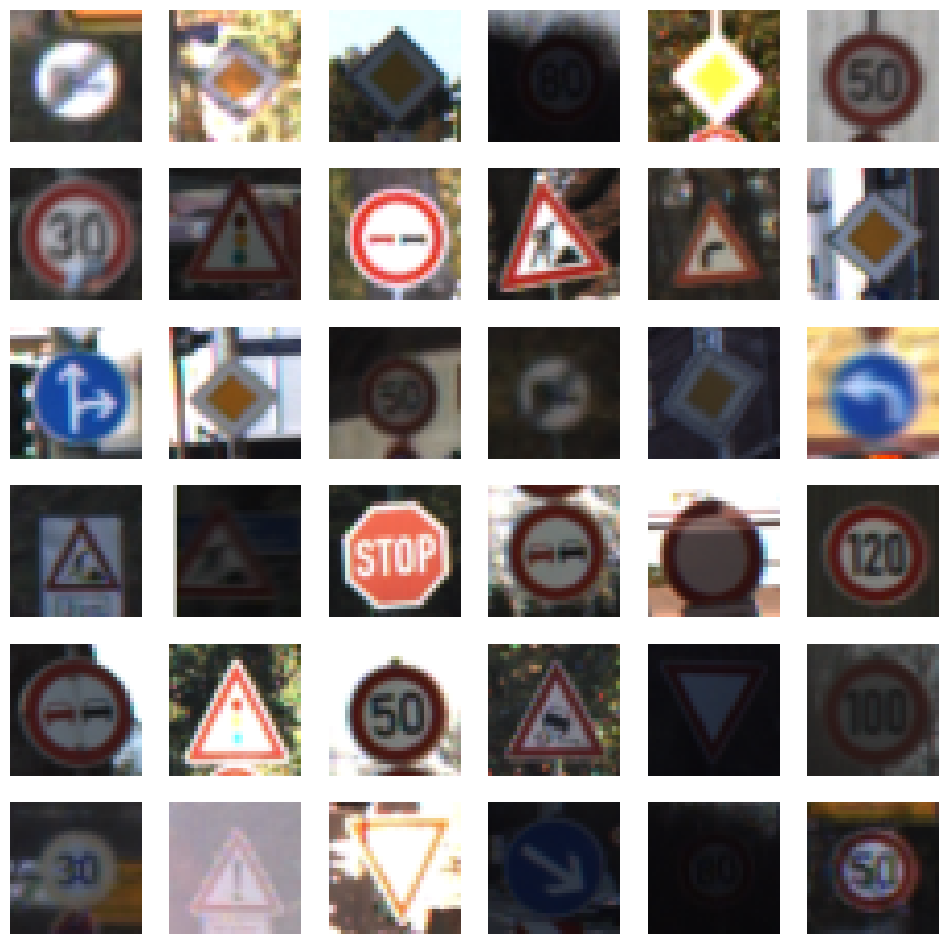

In [6]:
sz = 6
plt.figure(figsize=(2 * sz, 2 * sz))
for i in range(sz * sz):
    plt.subplot(sz, sz, i + 1)
    plt.imshow(x[np.random.randint(x.shape[0])])
    plt.axis('off')
plt.show()

In [7]:
sz = x.shape[0]
x = x.reshape(sz, -1)

In [8]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

In [9]:
model = LogisticRegression(n_jobs=-1, max_iter=1000)

In [10]:
model.fit(x_train, y_train)

LogisticRegression(max_iter=1000, n_jobs=-1)

In [11]:
y_pred = model.predict(x_test)

Все же склоняюсь взять в качестве метрики macro_precision, так как нам важно не просто общее количество верно угаданных знаков, а соотношение по классам (они могут быть неравных размеров)

In [12]:
score_logreg = precision_score(y_pred, y_test, average="macro")
print(f'accuracy {accuracy_score(y_pred, y_test):.5}, macro precision {score_logreg:.5}')

accuracy 0.95704, macro precision 0.94697


In [13]:
print(classification_report(y_pred, y_test))

              precision    recall  f1-score   support

           0       0.80      0.88      0.84        32
           1       0.94      0.93      0.94       392
           2       0.95      0.95      0.95       376
           3       0.91      0.90      0.90       255
           4       0.95      0.94      0.95       343
           5       0.94      0.89      0.91       333
           6       0.99      0.91      0.94        74
           7       0.93      0.94      0.93       228
           8       0.97      0.95      0.96       286
           9       0.94      0.97      0.95       233
          10       0.98      0.96      0.97       350
          11       0.98      0.96      0.97       224
          12       0.99      1.00      0.99       386
          13       0.97      0.98      0.98       406
          14       0.97      0.98      0.98       133
          15       0.91      0.92      0.91       118
          16       0.99      1.00      0.99        66
          17       0.98    

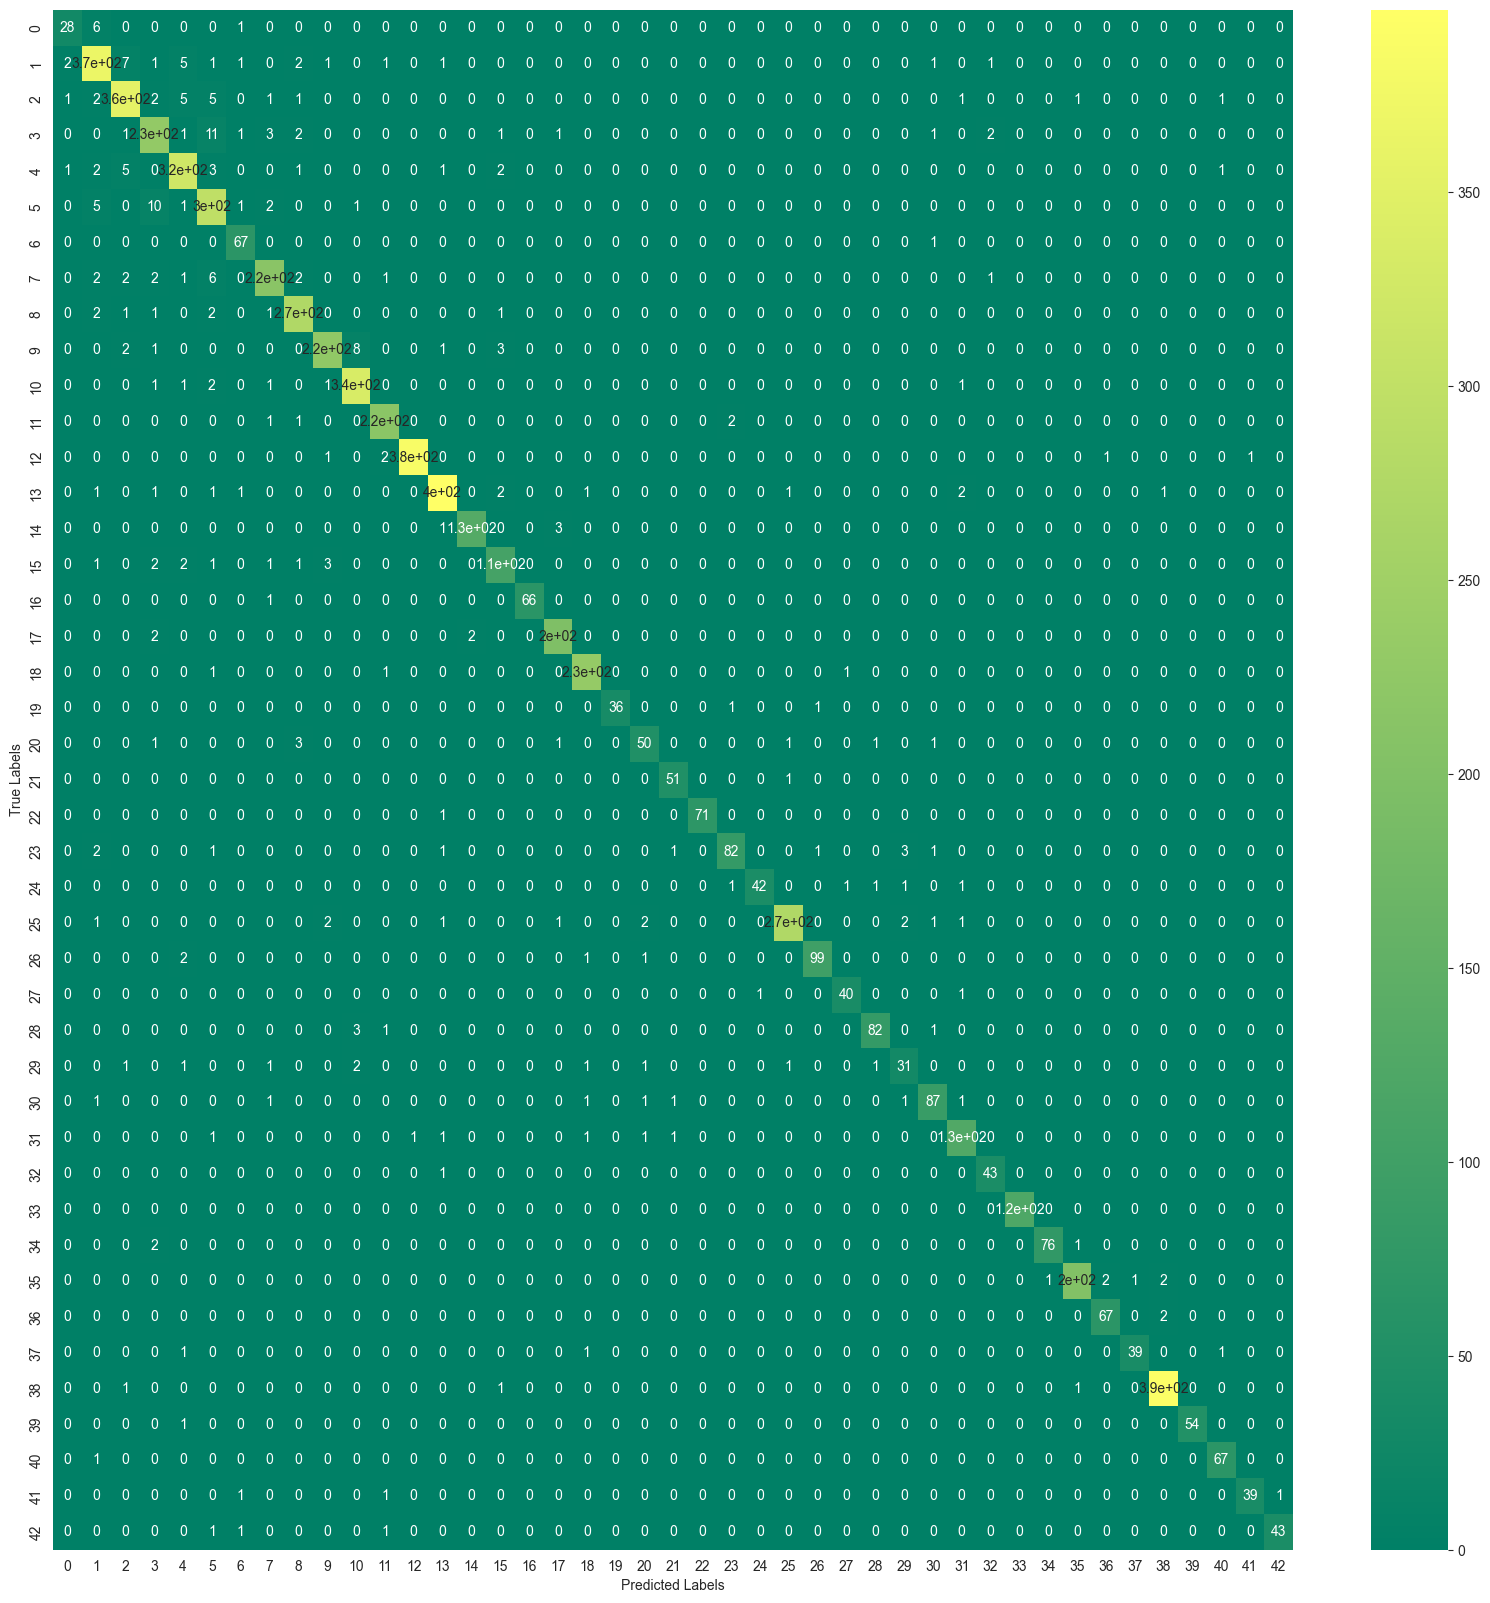

In [14]:
plt.figure(figsize=(20, 20))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, cmap='summer')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [15]:
sz = labels.shape[0]
max_conf = 0
cl1 = cl2 = None
for i in range(sz):
    for j in range(sz):
        if i != j and cm[i, j] > max_conf:
            max_conf = cm[i, j]
            cl1 = i
            cl2 = j

In [16]:
print(f'{max_conf} exemplars of {cl1} class ({labels.iloc[cl1]}) are confused as {cl2} class ({labels.iloc[cl2]})')

11 exemplars of 3 class (Speed limit (60km/h)) are confused as 5 class (Speed limit (80km/h))


## Medium

Обучить и сравнить между собой:

- логистическая регрессия
- kNN
- НБК
- SVM (попробовать 3 разных ядра)

Какая модель отработала лучше, а какая хуже всех?

Проинтерпретируйте почему худшая модель именно эта.

In [17]:
all_scores = {'logreg': score_logreg}

In [18]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB

In [19]:
knn = KNeighborsClassifier()
svm_lin = SVC(kernel="linear")
svm_poly = SVC(kernel="poly")
svm = SVC(kernel="rbf")
bayes = MultinomialNB()

In [20]:
models = {'knn': knn, 'svm': svm, 'svm_lin': svm_lin, 'svm_poly': svm_poly, 'bayes': bayes}

In [21]:
for name, model in models.items():
    print(f'Training model {name}')
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    score = precision_score(y_test, y_pred, average="macro")
    all_scores[name] = score

Training model knn
Training model svm
Training model svm_lin
Training model svm_poly
Training model bayes


In [22]:
max(all_scores, key=all_scores.get)

'svm_lin'

In [23]:
all_scores

{'logreg': 0.9469671074745313,
 'knn': 0.8998425246876643,
 'svm': 0.9314367276874184,
 'svm_lin': 0.9481278112439453,
 'svm_poly': 0.8710895388829637,
 'bayes': 0.41506011041102264}

bayes предполагает, что все признаки независимы, что является очень большим допущением